<a href="https://colab.research.google.com/github/dorian-goueytes/M1_SCE_TT_signal_S2/blob/main/TD3_Analyse_du_signal_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Durant ce TD nous allons analyser des données EEG issues d'une expérience dite "Oddball Paradigm"

## Structure et objectif :

Chaque section est constituée d'uns ou de plusieurs exercices dont l'objectif est d'implémenter une ou plusieurs étapes nécessaires à l'analyse des données EEG

Vous êtes encouragé.es à tenter de développer votre propre réponse aux consignes de chaque exercice.

**Néanmoins, les exercices étant plus avancés que dans les TDs précédents n'hésitez pas à vous inspirer des solutions proposées.**

**Vous êtes comme toujours encouragé.es à solliciter l'aide du professeur.**

Si l'exercice vous parait trop complexe vous pouvez regarder la solution proposée, et essayer de comprendre et de reproduire son fonctionnement.

Validez avec le professeur votre solution/compréhension de la solution avant de passer à l'exercice suivant.

## Principe de la tâche

Le paradigme oddball désigne un paradigme classique dans lequel les participants vont voir un flux rapide de stimuli "distracteurs". Rarement, un stimulus cible, différent des stimuli distracteurs, est présenté.

L'objectif du participant et de rapporté les stimuli cibles. Cette tâche tend à générer une réponse au niveau EEG appelé le P300 (ayant lieux 300ms après la présentation du stimulus). La P300 est normalement plus marquée pour les stimuli rares, et est considérée comme un marqueur de la détection d'une information imprévisible.

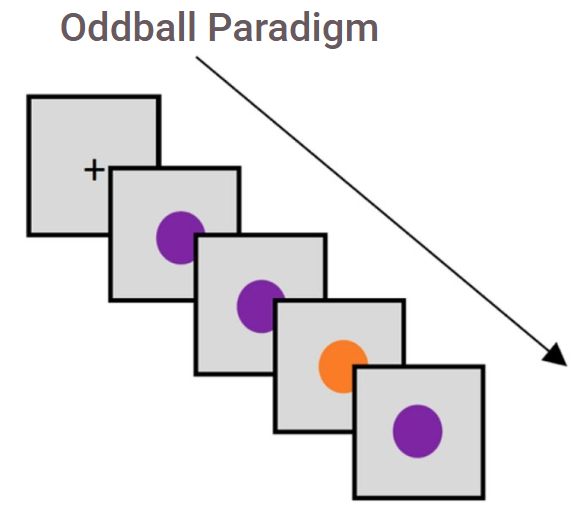

## Dos and Don'ts :


*   Vous êtes encouragé.es à travailler en binôme/trinôme et à échanger entre vous
*   Vous êtes encouragé.es à utiliser vos notes de cours.
*   Vous pouvez faire des recherches web et utiliser Stack Overflow pour alimenter vos réponses.
*   **ChatGPT ou tout autre LLM sont strictement interdit**

L'objectif du TD est de vous mettre en position de réfléchir activement à des questions de traitement du signal **ET** de développer votre autonomie en Python. Chaque exercice peut aisément être résolu par ChatGPT, mais votre apprentissage en sera diminué.

Les solutions aux exercices sont fournies dans le document, et vous êtes **très fortement encouragé.es à solliciter le professeur** en cas de blocage/difficulté à comprendre un exercice.

## Source :

(source des données [https://neurotechx.github.io/eeg-notebooks_v0.2/experiments/vp300.html](https://neurotechx.github.io/eeg-notebooks_v0.2/experiments/vp300.html))

# Importation des bibliothèques Python nécessaires

Il existe de nombreuses bibliothèques Python ou autre dédiés à l'analyse EEG. Chacune propose des outils et des formats de données différents. De sorte à avoir un enseignement général nous utiliserons aujourd'hui des bibliothèques généraliste (numpy et scipy principalement).

**Contrairement aux précédents cours vous êtes encouragé.es à chercher des solutions utilisant numpy et scipy. Les bibliothèques type mne-python ne sont pas autorisées (et ne sont pas utiles)**

In [ ]:
!pip install mne
import math
import matplotlib.pyplot as plt
import numpy as np
from mne.io import read_raw_fif
from mne import find_events, channel_type
import scipy.signal as ss
import scipy as sp

# Chargement et lecture des données

In [ ]:
raw_mne = read_raw_fif("TD_P300.fif")# lit les données depuis notre fichier

raw_data = raw_mne.get_data() #extraction du signal de chaque canal d'enregistrement dans la variable raw_ data
ch_names = raw_mne.info["ch_names"] # Contient les noms des différents canaux d'enregistrement
ch_types =  [channel_type(raw_mne.info, i) for i in np.arange(0, len(ch_names),1)] # Contient le type de canaux enregitrés (nous nous intéressons aux canaux 'eeg')
sfreq = raw_mne.info["sfreq"] # Fréquence d'échantillonage originelle
events_id = find_events(raw_mne)[:,2][1:] # Identité des stimulis présentés
events_sample = find_events(raw_mne)[:,0][1:] # Temps (en échantillons) de chaque stimuli

# Partie 1 : Contenu du signal brut et pré-traitement partiel

### Exercice 1 : Contenu fréquentiel

En vous basant sur les TDs précédents, calculez le contenu fréquentiel pour chaque canaux EEG de nos données brutes (vous pouvez utilisez les fonctions numpy fft.fft et fft.fftfreq)

In [ ]:
# Votre code ici

#### Solution

In [ ]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
for i, name in enumerate(ch_names):
  if ch_types[i] == 'eeg':

    # Compute the DFT using FFT
    X = np.fft.fft(raw_data[i])
    freqs = np.fft.fftfreq(len(raw_data[i]), d=1/sfreq)  # Frequency bins

    # Only keep the positive half of the spectrum
    X_magnitude = np.abs(X[:len(raw_data[i])//2])  # Magnitude spectrum
    freqs_half = freqs[:len(raw_data[i])//2]  # Positive frequencies
    axes[i].plot(freqs_half, X_magnitude)
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Magnitude")
    axes[i].set_ylim(0, max(X_magnitude[1:])+0.01)
    axes[i].set_xlim(1,110)
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

### Exercice 2 : Pré-traitement

 En vous basant sur les résultats de l'exercice précédent, quelle étape de pré-traitement recommanderiez vous? Implémentez la (indice, utilize scipy.iirnotch et scipy.filtfilt)

In [ ]:
# Votre code ici

#### Solution

In [ ]:
notch_freq = [50,100]
filt_data = []

for i,signal in enumerate(raw_data):
  for freq in notch_freq:
    num_b, den_a = ss.iirnotch(freq, 30, fs=sfreq)
    if freq == 50:
      filt_data.append(ss.filtfilt(num_b, den_a, signal))
    else:
      filt_data[i] = ss.filtfilt(num_b, den_a, filt_data[i])

fig, axes = plt.subplots(2,2)
axes = axes.flatten()
for i, name in enumerate(ch_names):
  if ch_types[i] == 'eeg':

    # Compute the DFT using FFT
    X = np.fft.fft(filt_data[i])
    freqs = np.fft.fftfreq(len(filt_data[i]), d=1/sfreq)  # Frequency bins
    # Only keep the positive half of the spectrum
    X_magnitude = np.abs(X[:len(filt_data[i])//2])  # Magnitude spectrum
    freqs_half = freqs[:len(filt_data[i])//2]  # Positive frequencies
    axes[i].plot(freqs_half, X_magnitude)
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Magnitude")
    axes[i].set_ylim(0, max(X_magnitude[1:])+0.01)
    axes[i].set_xlim(1,110)
    axes[i].axvline(notch_freq[0], color = 'k', linestyle = '--', alpha = 0.5)
    axes[i].axvline(notch_freq[1], color = 'k', linestyle = '--', alpha = 0.5)
    axes[i].set_title(name)
plt.suptitle("Frequency content after notch filtering")
plt.tight_layout()
plt.show()

print("Checking that filtering hasn't changed our data : ")
print("Shape of raw data : ", np.shape(raw_data))
print("Shape or filtered data : ", np.shape(filt_data))


# Partie 2 : Segmentation et Analyses préliminaires

### Exercice 3 : Segmentation en essai alignés sur les stimuli

Pour chaque canaux, segmentez le signal brut en essai allant de -0.5s avant le stimulus à 1s après le stimulus

In [ ]:
# Votre solution ici

#### Solution

In [ ]:
before = int(0.1*sfreq)
after =  int(0.8*sfreq)

seg_data = []
for channel in range(0, len(ch_names)):
  chan_seg = []
  for trial in range(0, len(events_sample)):
    segmentation_window = [int(events_sample[trial]-before), int(events_sample[trial]+after)]
    chan_seg.append(filt_data[channel][segmentation_window[0]:segmentation_window[1]])
  seg_data.append(np.array(chan_seg))
print(np.shape(np.array(seg_data)))



### Exercice 4 :  Visualisation simple

Construisez une figure pour visualiser l'activité moyenne de chaque canal alignée sur le stimulus

In [ ]:
# Votre solution ici

#### Solution

In [ ]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
time_axis = np.linspace(-before/sfreq,after/sfreq, np.shape(seg_data)[2])
for chan in range(0,np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    axes[chan].plot(time_axis, np.mean(seg_data[chan], axis = 0))
    axes[chan].set_xlabel("Time (s)")
    axes[chan].set_ylabel("Mean Voltage (µV)")
    axes[chan].axvline(0, color = 'k', linestyle = '--')
    axes[chan].axvline(0.3, color = 'gray', linestyle = '--')
    axes[chan].set_title(ch_names[chan])
plt.suptitle('Average Voltage across trial')
plt.tight_layout()
plt.show()


### Exercice 5 : Effet des stimulis rares

En vous basant sur l'exercice précédent, créez une figure dans laquelle pour chaque canaux est représenté séparément l'activité moyenne des essais avec un stimulus distracteur et un stimulus cible

In [ ]:
# Votre solution ici

#### Solution

In [ ]:
target_index = np.where(events_id == 2)[0]
ntarget_index = np.where(events_id == 1)[0]

fig, axes = plt.subplots(2,2, figsize = (10,8))
axes = axes.flatten()
time_axis = np.linspace(-before/sfreq,after/sfreq, np.shape(seg_data)[2])
for chan in range(0,np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    axes[chan].plot(time_axis, np.mean(seg_data[chan][target_index], axis = 0), label = 'Target')
    axes[chan].plot(time_axis, np.mean(seg_data[chan][ntarget_index], axis = 0), color = 'g', label = 'Non-target')
    axes[chan].set_xlabel("Time (s)")
    axes[chan].set_ylabel("Mean Voltage (µV)")
    axes[chan].axvline(0, color = 'k', linestyle = '--')
    axes[chan].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[chan].set_title(ch_names[chan])
    axes[chan].legend()
plt.suptitle('Average Voltage across trial')
plt.tight_layout()
plt.show()


# Partie 3 : Amélioration des données

### Exercice 6 : Suppression des artefacts

En vous basant sur le cours, implémentez une suppression automatiqu des artefacts basés sur la différence pic à pic.

**Rappel différence pic à pic :**  

Il s'agit de faire "glisser" une fenêtre temporelle sur le signal (ex. 100ms) et de comparer la différence entre le maximum et le minimum pour chaque fenêtre. Si cette valeur est trop élevé l'essai contrien probablement un blink, et doit être enlevé.

In [ ]:
# Votre solution ici

#### Solution

In [ ]:
rm_trial_index = []
window = int(0.1*sfreq)
time_axis = np.linspace(-before/sfreq,after/sfreq, np.shape(seg_data)[2])
threshold = 100e-6


for chan in range(0, np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    peaktopeak = []
    for trial in range(0, np.shape(seg_data)[1]):
      if chan == 0 and trial == 0:
        plt.figure()
        plt.plot(time_axis,seg_data[chan][trial], label = "Original Signal")
        plt.scatter(time_axis[0],seg_data[chan][trial][0],alpha = 0)
      for step in range(0, len(seg_data[chan][trial])//window):
        indexes = [step*window, step*window+window]
        if chan == 0 and trial == 0:
          plt.plot(time_axis[indexes[0]:indexes[1]],seg_data[chan][trial][indexes[0]:indexes[1]], linestyle = '--', alpha = 0.8)
          plt.scatter([time_axis[indexes[0]:indexes[1]][np.argmin(seg_data[chan][trial][indexes[0]:indexes[1]])],time_axis[indexes[0]:indexes[1]][np.argmax(seg_data[chan][trial][indexes[0]:indexes[1]])]],
          [min(seg_data[chan][trial][indexes[0]:indexes[1]]),max(seg_data[chan][trial][indexes[0]:indexes[1]])], s = 70)
      if chan == 0 and trial == 0:
        plt.legend()
        plt.xlabel("Temps (s)")
        plt.ylabel ("Voltage (µV)")
        plt.title("Exemple de segmentation sur un essai avec détection des pics")
        plt.tight_layout()
        plt.show()

fig, axes = plt.subplots(2,2, figsize = (8,6))
axes = axes.flatten()
for chan in range(0, np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    peaktopeak = []
    for trial in range(0, np.shape(seg_data)[1]):
      for step in range(0, len(seg_data[chan][trial])//window):
        indexes = [step*window, step*window+window]
        peaktopeak.append(max(seg_data[chan][trial][indexes[0]:indexes[1]])-min(seg_data[chan][trial][indexes[0]:indexes[1]]))
        if max(seg_data[chan][trial][indexes[0]:indexes[1]])-min(seg_data[chan][trial][indexes[0]:indexes[1]]) >=threshold:
          rm_trial_index.append(trial)

    axes[chan].hist(peaktopeak, bins = 50)
    axes[chan].axvline(100e-6, color = 'k', linestyle = '--')
    axes[chan].set_title(ch_names[chan])
    axes[chan].set_xlabel("Peak-to-Peak difference")
    axes[chan].set_ylabel("Count")
plt.suptitle("Distribution of peak-to-peak amplitude across channels, window = "+str(window/sfreq))
plt.show()

rm_trial_index = np.unique(rm_trial_index)
ratio = (len(rm_trial_index)/np.shape(seg_data)[1])*100
print()
print(str(ratio)+"% of trial excluded")

### Exercice 7 : Analyse avec exclusion

En vous basant sur l'exercice 5, recalculez l'effet des stimuli rares sur le jeu de données excluant les essais contenant un blink

In [ ]:
# Votre code ici

#### Solution

In [ ]:
rm_event_id = np.delete(events_id, rm_trial_index)# we create a copy of segmented data without the excluded trial
rm_seg_data = np.delete(seg_data, rm_trial_index, axis = 1) #we do the same for stimuli list

rm_target_index = np.where(rm_event_id == 2)[0]
rm_ntarget_index = np.where(rm_event_id == 1)[0]
target_index = np.where(events_id == 2)[0]
ntarget_index = np.where(events_id == 1)[0]

fig, axes = plt.subplots(4,2, figsize = (10,8))
axes = axes.flatten()
time_axis = np.linspace(-before/sfreq,after/sfreq, np.shape(rm_seg_data)[2])
fig_index = 0

for chan in range(0,np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    axes[fig_index].plot(time_axis, np.mean(seg_data[chan][target_index], axis = 0), label = 'Target')
    axes[fig_index].plot(time_axis, np.mean(seg_data[chan][ntarget_index], axis = 0), color = 'g', label = 'Non-target')
    axes[fig_index].set_xlabel("Time (s)")
    axes[fig_index].set_ylabel("Mean Voltage (µV)")
    axes[fig_index].axvline(0, color = 'k', linestyle = '--')
    axes[fig_index].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[fig_index].set_title(ch_names[chan]+' or. data')
    axes[fig_index].legend()
    fig_index+=1

    axes[fig_index].plot(time_axis, np.mean(rm_seg_data[chan][rm_target_index], axis = 0), label = 'Target')
    axes[fig_index].plot(time_axis, np.mean(rm_seg_data[chan][rm_ntarget_index], axis = 0), color = 'g', label = 'Non-target')
    axes[fig_index].set_xlabel("Time (s)")
    axes[fig_index].set_ylabel("Mean Voltage (µV)")
    axes[fig_index].axvline(0, color = 'k', linestyle = '--')
    axes[fig_index].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[fig_index].set_title(ch_names[chan]+' rm. data')
    axes[fig_index].legend()
    fig_index+=1
plt.suptitle('Average Voltage across trial')
plt.tight_layout()
plt.show()


### Exercice 8 : Baselining

Un autre facteur pouvant affecter les données est le drift au cours de la session. Cela peut générer un voltage devenant progressivement plus élevé au cours du temps, indépendamment de l'expérience. Pour contrôler cet effet une technique commune est la baseline.

En vous basant sur la définition suivante appliquez une baseline et refaite l'analyse des exercices 5 et 7

**Baseline:**

Une méthode classique consiste pour chaque essai à prendre la moyenne du signal dans une période précédent le stim onset (ici -0.1s - 0s) et à soustraire cette valeur à chaque point de donnée dans l'essai

In [ ]:
# Votre code ici

#### Solution

In [ ]:
seg_data_baseline = []
for channel in range(0, len(ch_names)):
  chan_seg_baseline = []
  for trial in range(0, len(events_sample)):
    segmentation_window = [int(events_sample[trial]-before), int(events_sample[trial]+after)]
    baseline_window = [int(events_sample[trial]-before), int(events_sample[trial])]
    baseline_segment = filt_data[channel][baseline_window[0]:baseline_window[1]]
    baseline_mean = np.mean(baseline_segment)
    chan_seg_baseline.append(filt_data[channel][segmentation_window[0]:segmentation_window[1]]-baseline_mean)
  seg_data_baseline.append(np.array(chan_seg_baseline))

target_index = np.where(events_id == 2)[0]
ntarget_index = np.where(events_id == 1)[0]

fig, axes = plt.subplots(4,2, figsize = (10,8))
axes = axes.flatten()
time_axis = np.linspace(-before/sfreq,after/sfreq, np.shape(rm_seg_data)[2])
fig_index = 0

for chan in range(0,np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    axes[fig_index].plot(time_axis, np.mean(seg_data[chan][target_index], axis = 0), label = 'Target')
    axes[fig_index].plot(time_axis, np.mean(seg_data[chan][ntarget_index], axis = 0), color = 'g', label = 'Non-target')
    axes[fig_index].set_xlabel("Time (s)")
    axes[fig_index].set_ylabel("Mean Voltage (µV)")
    axes[fig_index].axvline(0, color = 'k', linestyle = '--')
    axes[fig_index].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[fig_index].set_title(ch_names[chan]+' or. data')
    axes[fig_index].legend()
    fig_index+=1

    axes[fig_index].plot(time_axis, np.mean(seg_data_baseline[chan][target_index], axis = 0), label = 'Target')
    axes[fig_index].plot(time_axis, np.mean(seg_data_baseline[chan][ntarget_index], axis = 0), color = 'g', label = 'Non-target')
    axes[fig_index].set_xlabel("Time (s)")
    axes[fig_index].set_ylabel("Mean Voltage (µV)")
    axes[fig_index].axvline(0, color = 'k', linestyle = '--')
    axes[fig_index].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[fig_index].set_title(ch_names[chan]+' Bas. data')
    axes[fig_index].legend()
    fig_index+=1
plt.suptitle('Average Voltage across trial')
plt.tight_layout()
plt.show()


### Exercice 9 : Lissage

De manière à faciliter la visualisation des données, il est fréquent de lisser les données. Il s'agit en réalité d'appliquer un filtre éliminant les plus hautes fréquences du signal

Visualisez les données lissées par l'application d'un filtre de Savitzky-Golay (scipy.signal.savgol_filter)

In [ ]:
# Paramètres pour le filtre
window_length = int(np.shape(seg_data)[2]/10)
polyorder = 2
# Votre code ici

#### Solution

In [ ]:
target_index = np.where(events_id == 2)[0]
ntarget_index = np.where(events_id == 1)[0]

fig, axes = plt.subplots(4,2, figsize = (10,8))
axes = axes.flatten()
time_axis = np.linspace(-before/sfreq,after/sfreq, np.shape(rm_seg_data)[2])
fig_index = 0
print(np.shape(seg_data))
for chan in range(0,np.shape(seg_data)[0]):
  if ch_types[chan] == "eeg":
    axes[fig_index].plot(time_axis, np.mean(seg_data[chan][target_index], axis = 0), label = 'Target')
    axes[fig_index].plot(time_axis, np.mean(seg_data[chan][ntarget_index], axis = 0), color = 'g', label = 'Non-target')
    axes[fig_index].set_xlabel("Time (s)")
    axes[fig_index].set_ylabel("Mean Voltage (µV)")
    axes[fig_index].axvline(0, color = 'k', linestyle = '--')
    axes[fig_index].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[fig_index].set_title(ch_names[chan]+' or. data')
    axes[fig_index].legend()
    fig_index+=1

    axes[fig_index].plot(time_axis, np.mean(ss.savgol_filter(seg_data[chan][target_index],int(np.shape(seg_data)[2]/10),2, axis = 1), axis = 0), label = 'Target')
    axes[fig_index].plot(time_axis, np.mean(ss.savgol_filter(seg_data[chan][ntarget_index],int(np.shape(seg_data)[2]/10),2,axis = 1), axis = 0), color = 'g', label = 'Non-target')
    axes[fig_index].set_xlabel("Time (s)")
    axes[fig_index].set_ylabel("Mean Voltage (µV)")
    axes[fig_index].axvline(0, color = 'k', linestyle = '--')
    axes[fig_index].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
    axes[fig_index].set_title(ch_names[chan]+' Liss. data')
    #axes[fig_index].legend()
    fig_index+=1
plt.suptitle('Average Voltage across trial')
plt.tight_layout()
plt.show()


# Bonus : Spectrogramme

### Exercice 10 : Générer un spectrogramme

En vous basant sur l'exercice 7 du TD2, essayer de générer un graphique de l'évolution des amplitudes des différentes bandes de fréquence au cours du temps pour chaque canal.

**Indice :**

Il s'agit d'appliquer une Short-Time Fourier Transform (scipy.signal.stft) à chaque essai et de prendre la moyenne au travers des essais pour chaque canal

In [ ]:
# Votre code ici

#### Solution

In [ ]:
from scipy.signal import stft

# Compute STFT for each trial and average the power spectral density (PSD)
nperseg = 92  # Segment length for STFT
noverlap = nperseg // 2  # 50% overlap

fig, axes = plt.subplots(2,2, figsize = (10,8))
axes = axes.flatten()
for chan in range(0, np.shape(seg_data)[0]):
  if ch_types[chan] == 'eeg':
    # Initialize power spectrum accumulator
    psd_sum = None
    #freqs = None
    #times = None

    for trial in seg_data[chan]:
        f, t, Zxx = stft(trial, fs=sfreq, nperseg=nperseg, noverlap=noverlap)
        psd = np.abs(Zxx) ** 2  # Compute power spectrum
        if psd_sum is None:
            psd_sum = psd
            #freqs = f
            #times = t
        else:
            psd_sum += psd

    # Average PSD over trials
    psd_avg = psd_sum / np.array(seg_data).shape[0]

    # Plot the power spectrum over time using imshow
    axes[chan].imshow(10 * np.log10(psd_avg), aspect='auto', origin='lower', extent=[-0.1, 0.8, 0, 120], cmap='jet', interpolation = 'hanning')
    axes[chan].set_xlabel('Time (s)')
    axes[chan].set_ylabel('Frequency (Hz)')
    axes[chan].set_title(ch_names[chan])
    axes[chan].axvline(0, color = 'k', linestyle = '--')
    axes[chan].axvline(0.3, color = 'gray', linestyle = '--', alpha = 0.5)
plt.suptitle('EEG Power Spectrum Over Time')
#plt.colorbar(label='Power (dB)')
plt.tight_layout()
plt.show()
